# motion estimation figure2








In [1]:
%load_ext autoreload
%autoreload 2 # what is this for exactly?

In [2]:
%matplotlib inline
# %matplotlib widget

In [3]:
from pathlib import Path

import spikeinterface.full as si

import numpy as np
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (20, 12)

from probeinterface.plotting import plot_probe


from spikeinterface.sortingcomponents import detect_peaks
from spikeinterface.sortingcomponents import localize_peaks

In [4]:
# local folder
base_folder = Path('/media/e4/data1/CorinnasData/raw_data/bird1')

name = 'raw_awake'
dataset_folder = base_folder / name
preprocess_folder = base_folder / f'{name}_preprocessed'

peak_folder = base_folder / f'{name}_peaks'

peak_folder.mkdir(exist_ok=True)

In [5]:
# global kwargs for parallel computing
job_kwargs = dict(
    n_jobs=30,
    chunk_memory='10M',
    progress_bar=True,
)

In [6]:
# read the file
rec = si.read_spikeglx(dataset_folder, stream_id='imec0.ap')
rec

SpikeGLXRecordingExtractor: 384 channels - 1 segments - 30.0kHz - 3881.358s

(-50.0, 400.0)

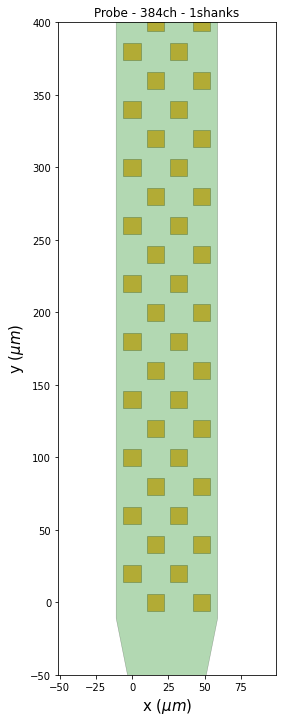

In [7]:
fig, ax = plt.subplots()

plot_probe(rec.get_probe(), ax=ax)
ax.set_ylim(-50, 400)

# TODO plot how peaks per channel

## preprocess

This take 4 min for 30min of signals

In [8]:
if si.load_extractor(preprocess_folder):
    # load back
    rec_preprocessed = si.load_extractor(preprocess_folder)
    rec_preprocessed
else:
    rec_filtered = si.bandpass_filter(rec, freq_min=300., freq_max=6000.)
    rec_preprocessed = si.common_reference(rec_filtered, reference='local',
                                        local_radius=(50, 100), operator='median')
    rec_preprocessed.save(folder=preprocess_folder, **job_kwargs)

Versions are not the same. This might lead to errors. Use  spikeinterface version 0.92.1.dev0
Versions are not the same. This might lead to errors. Use  spikeinterface version 0.92.1.dev0


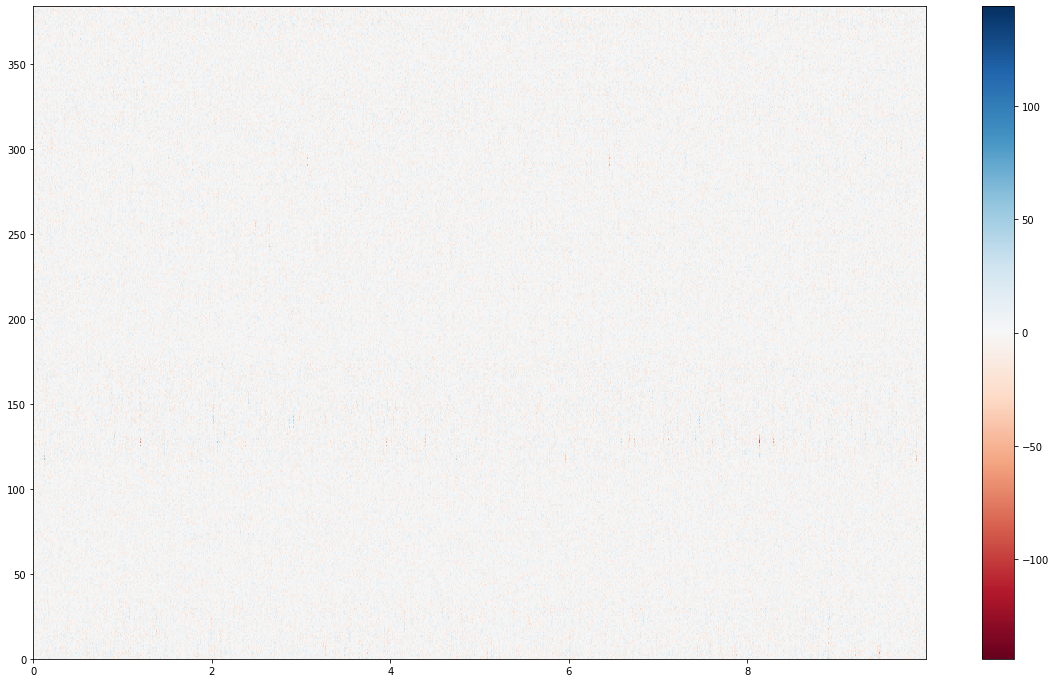

In [9]:
fig, ax = plt.subplots()
si.plot_timeseries(rec_preprocessed,
                   time_range=(0, 10),
                   # channel_ids = rec_preprocessed.channel_ids[60:70],
                   ax=ax)

## estimate noise

(array([  1.,   0.,   0., 265.,   0.,   0., 114.,   0.,   0.,   4.]),
 array([10.424389, 11.466827, 12.509267, 13.551705, 14.594145, 15.636583,
        16.679022, 17.72146 , 18.7639  , 19.80634 , 20.848778],
       dtype=float32),
 <BarContainer object of 10 artists>)

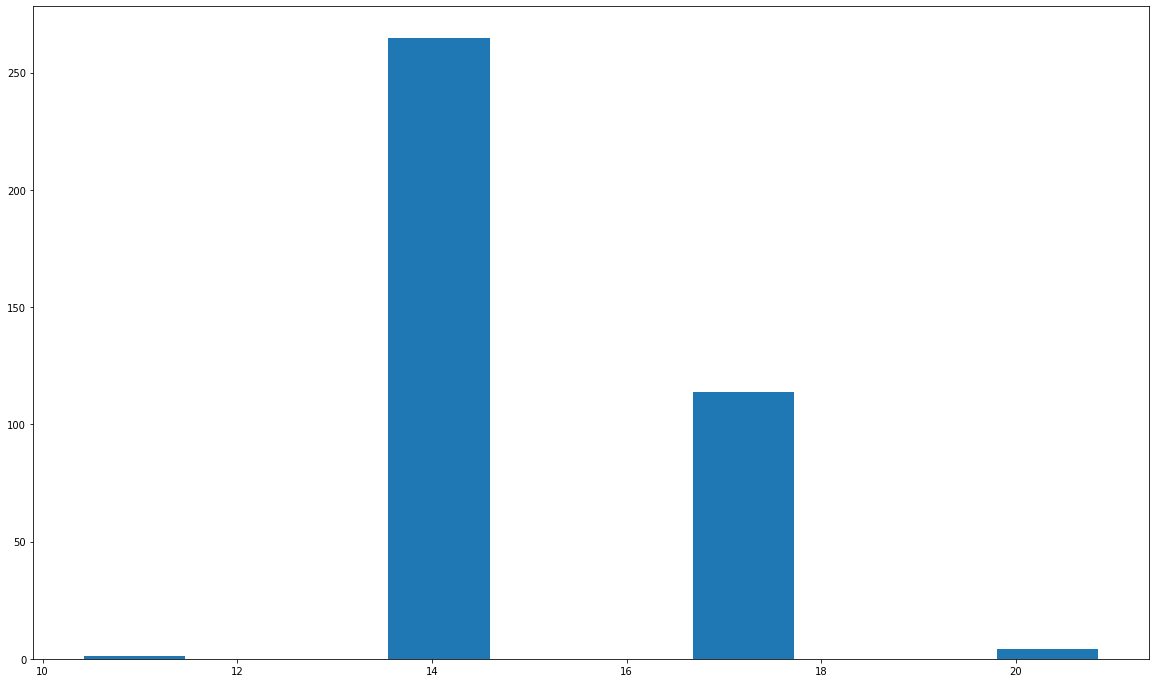

In [10]:
noise_levels_scaled = si.get_noise_levels(rec_preprocessed, return_scaled=True)

fig, ax = plt.subplots()
ax.hist(noise_levels_scaled)


## detect peaks

This take 1min30s

In [11]:
from spikeinterface.sortingcomponents import detect_peaks

In [12]:
if (peak_folder / 'peaks.npy').exists():
    # load back
    peaks = np.load(peak_folder / 'peaks.npy')
else:
    peaks = detect_peaks(rec_preprocessed, method='locally_exclusive', local_radius_um=50,
                    peak_sign='neg', detect_threshold=5, n_shifts=5,
                    noise_levels=noise_levels_scaled, **job_kwargs) # changed to scaled here, is that okk?
    np.save(peak_folder / 'peaks.npy', peaks)

## localize peaks

We use 2 methods:
  * 'center_of_mass': 9 s
  * 'monopolar_triangulation' : 26min

In [13]:
from spikeinterface.sortingcomponents import localize_peaks

In [14]:
if (peak_folder / 'peak_locations_monopolar_triangulation.npy').exists():
    # load back
    peak_locations = np.load(peak_folder / 'peak_locations_monopolar_triangulation.npy')

else: 
    peak_locations = localize_peaks(rec_preprocessed, peaks,
                   ms_before=0.3, ms_after=0.6,
                   method='monopolar_triangulation', method_kwargs={'local_radius_um': 100., 'max_distance_um': 1000.},
                   **job_kwargs)
    np.save(peak_folder / 'peak_locations_monopolar_triangulation.npy', peak_locations)


localize peaks: 100%|██████████| 8944/8944 [15:44<00:00,  9.47it/s] 


## plot peak on probe

(1500.0, 2500.0)

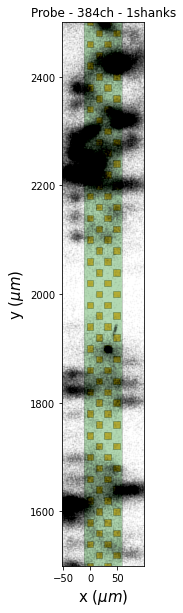

In [15]:
probe = rec_preprocessed.get_probe()

fig, ax = plt.subplots(figsize=(15, 10))
plot_probe(probe, ax=ax)
ax.scatter(peak_locations['x'], peak_locations['y'], color='k', s=1, alpha=0.02)
# ax.set_ylim(2400, 2900)
ax.set_ylim(1500, 2500)

## plot peak depth vs time

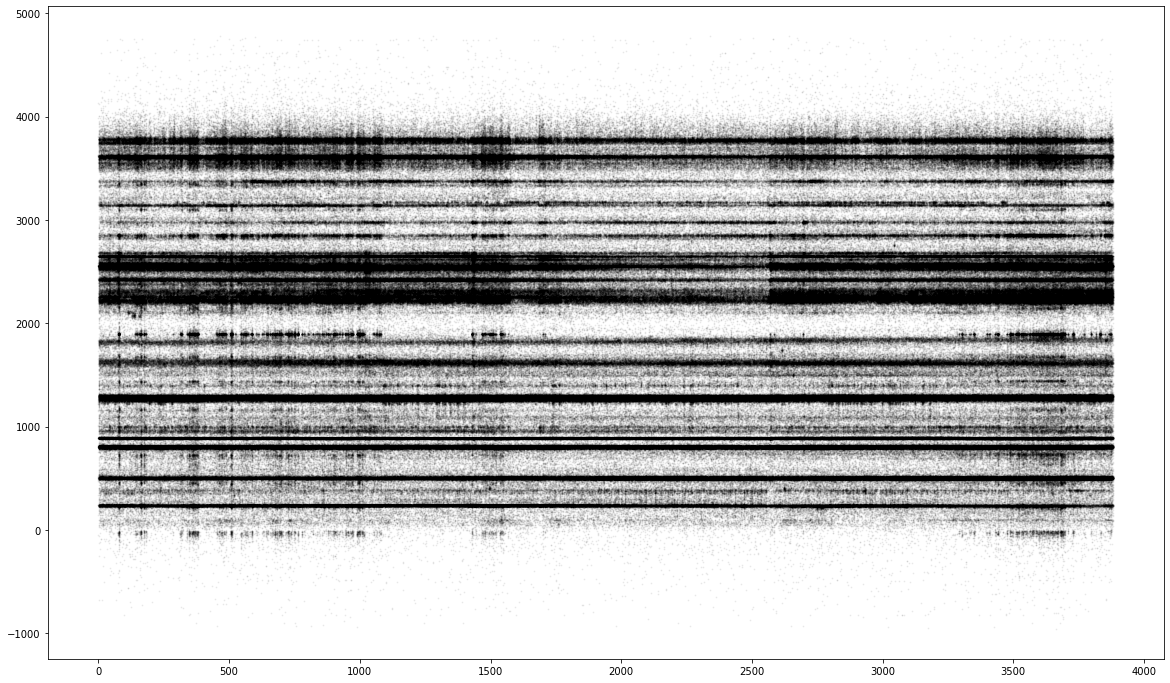

In [16]:
fig, ax = plt.subplots()
x = peaks['sample_ind'] / rec_preprocessed.get_sampling_frequency()
y = peak_locations['y']
ax.scatter(x, y, s=1, color='k', alpha=0.05)
# ax.set_ylim(1300, 2500)

# fig.savefig(peak_folder / 'MT_motion_raster.png')

## motion estimate : rigid with decentralized

In [17]:
from spikeinterface.sortingcomponents import (estimate_motion, make_motion_histogram,
    compute_pairwise_displacement, compute_global_displacement)

In [18]:
bin_um = 2
bin_duration_s = 5.

motion_histogram, temporal_bins, spatial_bins = make_motion_histogram(rec_preprocessed, peaks,
    peak_locations=peak_locations, 
    bin_um=bin_um, bin_duration_s=bin_duration_s,
    direction='y', weight_with_amplitude=False)


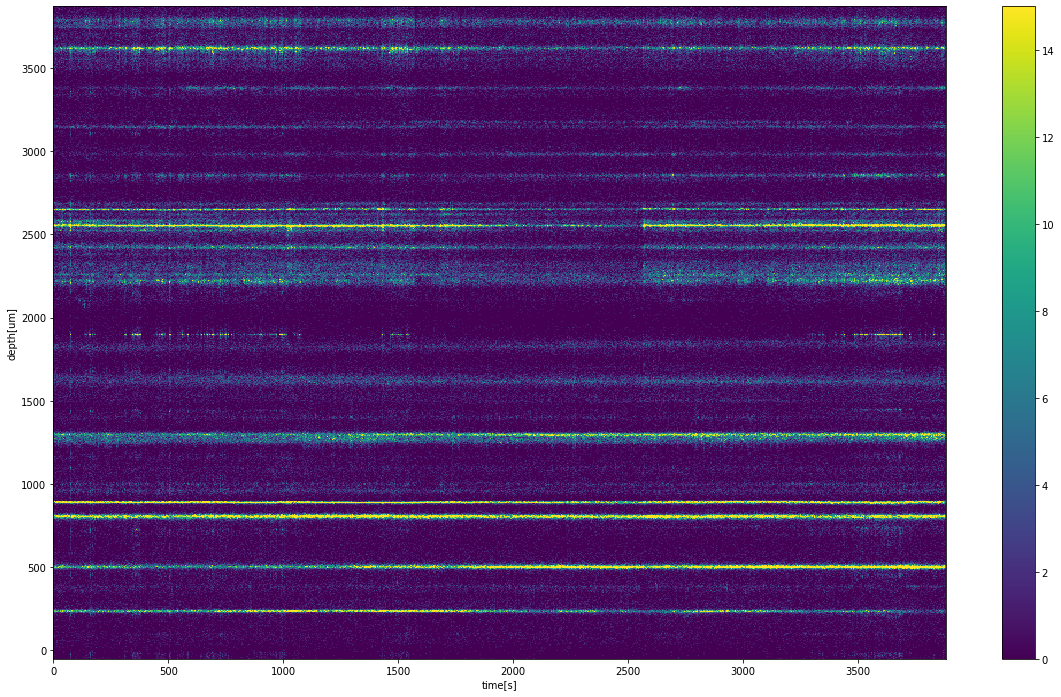

In [19]:
fig, ax = plt.subplots()
extent = (temporal_bins[0], temporal_bins[-1], spatial_bins[0], spatial_bins[-1])
im = ax.imshow(motion_histogram.T, interpolation='nearest',
                    origin='lower', aspect='auto', extent=extent)
im.set_clim(0, 15)
# ax.set_ylim(1300, 2500)
ax.set_xlabel('time[s]')
ax.set_ylabel('depth[um]')

fig.colorbar(im)
# fig.savefig(peak_folder / 'MT_motion_histogram.png')

## plot one bins of histogram

150
[0. 0. 0. ... 2. 0. 0.]


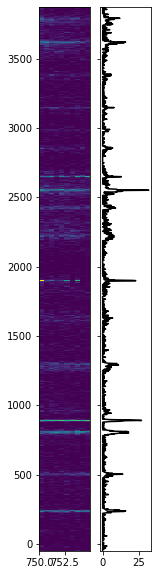

In [20]:
t = 750.
ind = np.argmin(np.abs(temporal_bins - t))
print(ind)
h = motion_histogram[ind, :]
print(h)

fig, axs = plt.subplots(ncols=2, sharey=True, figsize=(2,10))
extent = (temporal_bins[ind], temporal_bins[ind+1], spatial_bins[0], spatial_bins[-1])
im = axs[0].imshow(motion_histogram[ind-5:ind+5, :].T, interpolation='nearest',
                    origin='lower', aspect='auto', extent=extent)

axs[1].plot(h, spatial_bins[:-1], color='k')
# fig.savefig(peak_folder / 'MT_histogram_peak_along_depth_750.png')


## pariwise displacement from the motion histogram


In [21]:
if (peak_folder / 'MT_pairwise_displacement_conv2d.npy').exists():
    pairwise_displacement = np.load(peak_folder / 'MT_pairwise_displacement_conv2d.npy')
else: 
    pairwise_displacement = compute_pairwise_displacement(motion_histogram, bin_um, method='conv2d', progress_bar=True)
    np.save(peak_folder / 'MT_pairwise_displacement_conv2d.npy', pairwise_displacement)

100%|██████████| 777/777 [06:21<00:00,  2.04it/s]


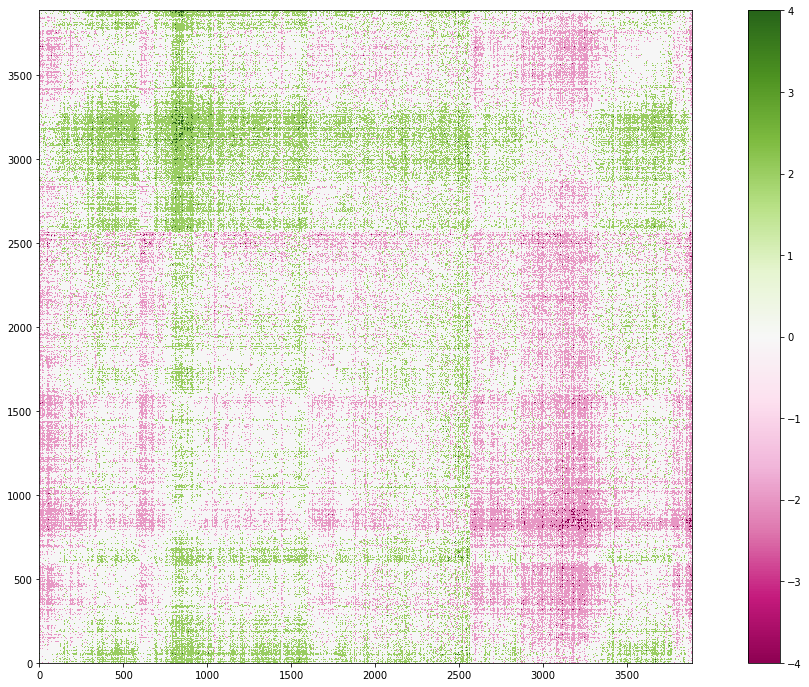

In [22]:
fig, ax = plt.subplots()
extent = (temporal_bins[0], temporal_bins[-1], temporal_bins[0], temporal_bins[-1])
# extent = None
im = ax.imshow(pairwise_displacement, interpolation='nearest',
                    cmap='PiYG', origin='lower', aspect='auto', extent=extent)
#im.set_clim(-40, 30)
ax.set_aspect('equal')
fig.colorbar(im)
# fig.savefig(peak_folder / 'MT_pairwise_displacement.png')

## estimate motion (rigid) from the pariwise discplaement

In [23]:
motion = compute_global_displacement(pairwise_displacement)

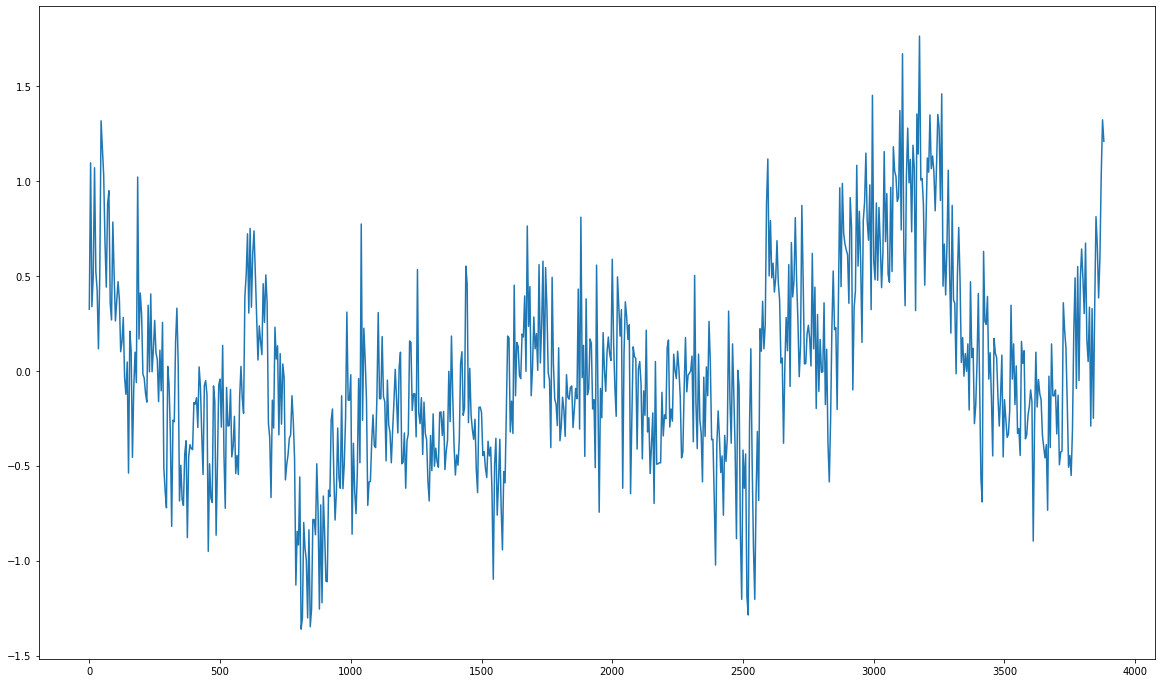

In [24]:
fig, ax = plt.subplots()
ax.plot(temporal_bins[:-1], motion)
# fig.savefig(peak_folder / 'MT_motion_esmiated_rigid.png')


## motion estimation with one unique funtion

Internanly `estimate_motion()` do:
  * make_motion_histogram()
  * compute_pairwise_displacement()
  * compute_global_displacement()
  

In [25]:
if ((peak_folder / 'MT_motion_rigid.npy').exists() & (peak_folder / 'MT_temporal_bins_rigid.npy').exists()):
    motion = np.load(peak_folder / 'MT_motion_rigid.npy')
    temporal_bins = np.load(peak_folder / 'MT_temporal_bins_rigid.npy')
else:
        
    motion, temporal_bins, spatial_bins = estimate_motion(rec_preprocessed, peaks, peak_locations=peak_locations,
                        direction='y', bin_duration_s=5., bin_um=10.,
                        method='decentralized_registration', method_kwargs={},
                        non_rigid_kwargs=None, 
                        progress_bar=True, verbose=True)

    np.save(peak_folder / 'MT_motion_rigid.npy', motion)
    np.save(peak_folder / 'MT_temporal_bins_rigid.npy', temporal_bins)


Computing motion histogram
Computing pairwise displacement: 1 / 1


100%|██████████| 777/777 [00:21<00:00, 36.99it/s]


Computing global displacement: 1 / 1


ValueError: x and y must have same first dimension, but have shapes (776,) and (777, 1)

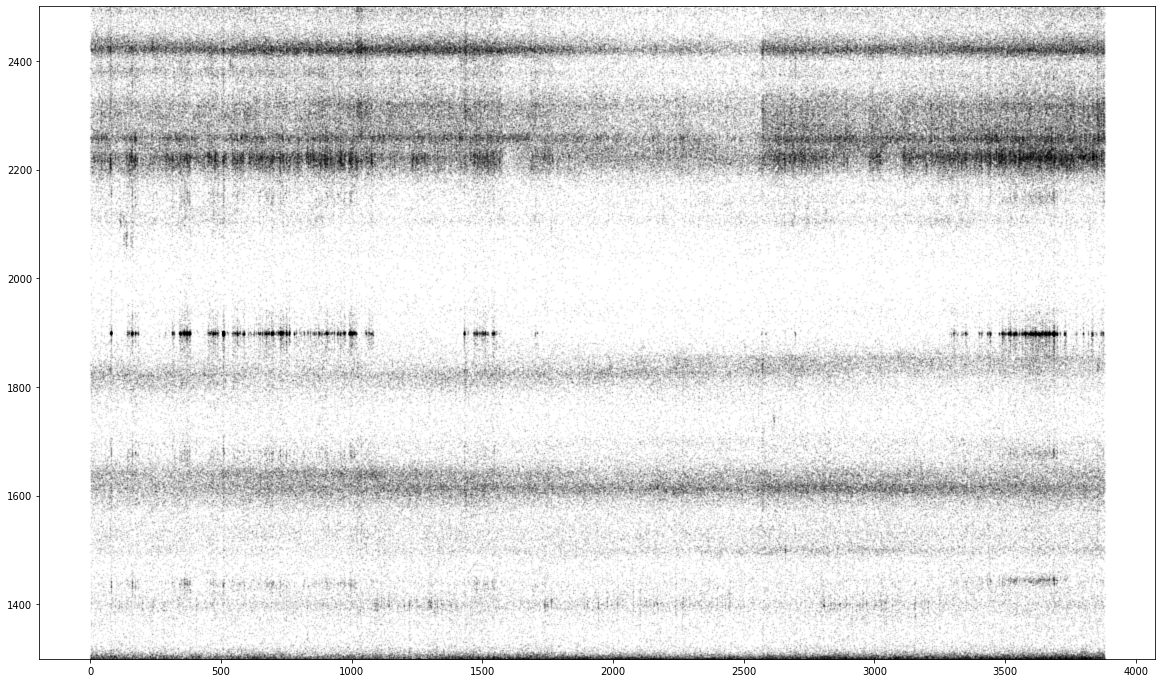

In [26]:
fig, ax = plt.subplots()
x = peaks['sample_ind'] / rec_preprocessed.get_sampling_frequency()
y = peak_locations['y']
ax.scatter(x, y, s=1, color='k', alpha=0.05)
ax.set_ylim(1300, 2500)


ax.plot(temporal_bins[:-1], motion + 2000, color='r')
ax.set_xlabel('times[s]')
ax.set_ylabel('motion [um]')
# fig.savefig(peak_folder / 'MT_glob_rigid.png')

## motion estimation non rigid

In [27]:
if ((peak_folder / 'MT_motion_non_rigid.npy').exists() & (peak_folder / 'MT_temporal_bins_non_rigid.npy').exists() & (peak_folder / 'MT_spatial_bins_non_rigid.npy').exists()):
    motion = np.load(peak_folder / 'MT_motion_non_rigid.npy')
    temporal_bins = np.load(peak_folder / 'MT_temporal_bins_non_rigid.npy')
    spatial_bins = np.load(peak_folder / 'MT_spatial_bins_non_rigid.npy')
else:
    motion, temporal_bins, spatial_bins = estimate_motion(rec_preprocessed, peaks, peak_locations=peak_locations,
                        direction='y', bin_duration_s=5., bin_um=10.,
                        method='decentralized_registration', method_kwargs={},
                        non_rigid_kwargs=dict(bin_step_um=100),
                        progress_bar=True, verbose=False)

    np.save(peak_folder / 'MT_motion_non_rigid.npy', motion)
    np.save(peak_folder / 'MT_temporal_bins_non_rigid.npy', temporal_bins)
    np.save(peak_folder / 'MT_spatial_bins_non_rigid.npy', spatial_bins)


100%|██████████| 777/777 [01:34<00:00,  8.19it/s]


ValueError: x and y must have same first dimension, but have shapes (776,) and (777,)

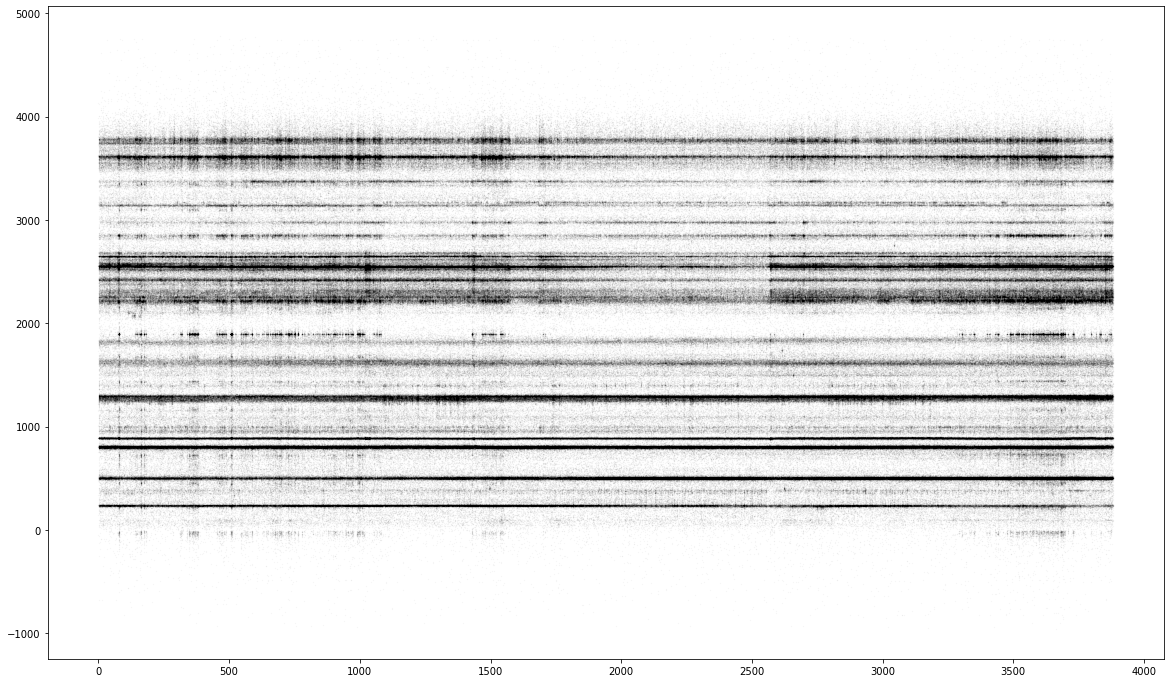

In [29]:
fs = rec_preprocessed.get_sampling_frequency()

fig, ax = plt.subplots()
ax.scatter(peaks['sample_ind'] / fs, peak_locations['y'], color='k', s=0.1, alpha=0.05)


for i, s_bins in enumerate(spatial_bins):
     # several motion vector
     ax.plot(temporal_bins[:-1], motion[:, i] + spatial_bins[i], color='r')

ax.set_ylim(1300, 2500)
ax.set_xlabel('times[s]')
ax.set_ylabel('motion [um]')

## correct **rigid** motion on peak location

In [30]:
from spikeinterface.sortingcomponents import correct_motion_on_peaks, correct_motion_on_traces

In [31]:
motion = np.load(peak_folder / 'MT_motion_rigid.npy')
temporal_bins = np.load(peak_folder / 'MT_temporal_bins_rigid.npy')
spatial_bins = None

In [32]:
times = rec_preprocessed.get_times()
corrected_peak_locations_rigid = correct_motion_on_peaks(peaks, peak_locations, times,
        motion, temporal_bins, spatial_bins,
        direction='y')

ValueError: x and y must have same first dimension, but have shapes (776,) and (777, 1)

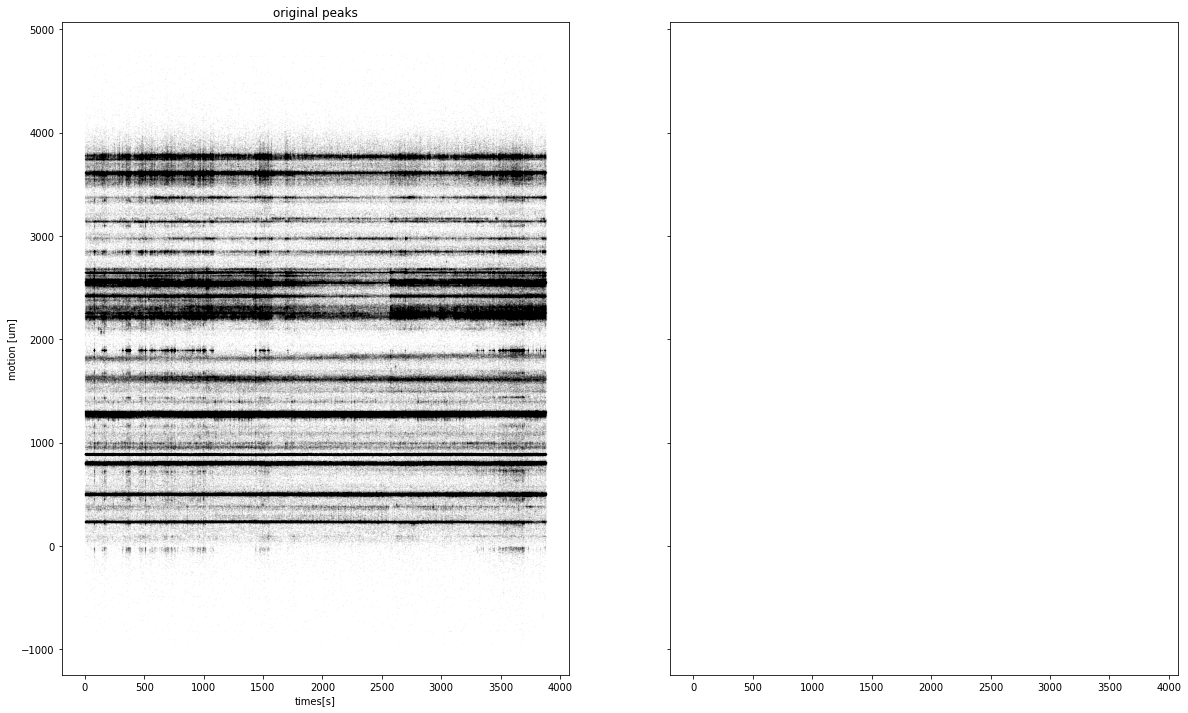

In [33]:
fs = rec_preprocessed.get_sampling_frequency()

fig, axs = plt.subplots(ncols=2, sharex=True, sharey=True)

ax = axs[0]
ax.scatter(peaks['sample_ind'] / fs, peak_locations['y'], color='k', s=0.1, alpha=0.05)
# ax.set_ylim(1300, 2500)
ax.set_xlabel('times[s]')
ax.set_ylabel('motion [um]')
ax.set_title('original peaks')

av_depth = 2000 # for plotting
ax.plot(temporal_bins[:-1], motion + av_depth, color='r')

ax = axs[1]
ax.scatter(peaks['sample_ind'] / fs, corrected_peak_locations_rigid['y'], color='k', s=0.1, alpha=0.05)
ax.set_xlabel('times[s]')
ax.set_ylabel('motion [um]')
ax.set_title('rigid corrected')

ax.set_ylim(1300, 2500)


## correct **non rigid** motion on peak location

In [34]:
motion = np.load(peak_folder / 'MT_motion_non_rigid.npy')
temporal_bins = np.load(peak_folder / 'MT_temporal_bins_non_rigid.npy')
spatial_bins = np.load(peak_folder / 'MT_spatial_bins_non_rigid.npy')

In [35]:
times = rec_preprocessed.get_times()
corrected_peak_locations_non_rigid = correct_motion_on_peaks(peaks, peak_locations, times,
        motion, temporal_bins, spatial_bins,
        direction='y', progress_bar=True)

ValueError: x and y must have same first dimension, but have shapes (776,) and (777,)

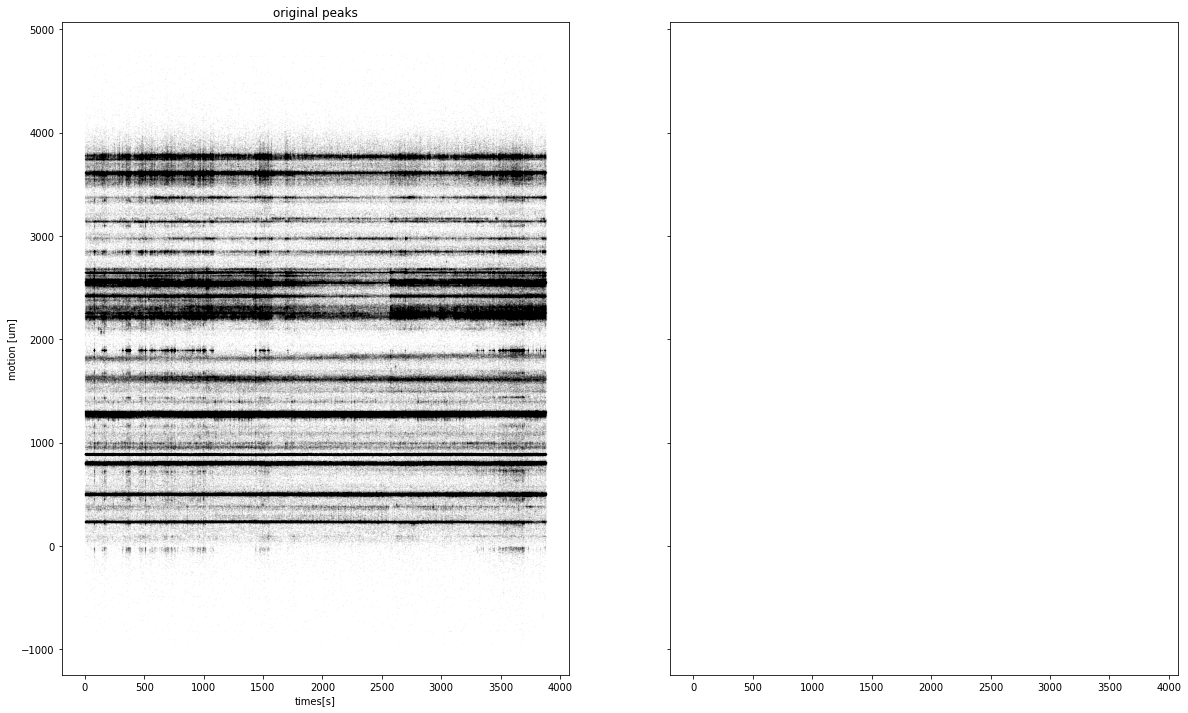

In [36]:
fs = rec_preprocessed.get_sampling_frequency()

fig, axs = plt.subplots(ncols=2, sharex=True, sharey=True)

ax = axs[0]
ax.scatter(peaks['sample_ind'] / fs, peak_locations['y'], color='k', s=0.1, alpha=0.05)
# ax.set_ylim(1300, 2500)
ax.set_xlabel('times[s]')
ax.set_ylabel('motion [um]')
ax.set_title('original peaks')

for i, s_bins in enumerate(spatial_bins):
     ax.plot(temporal_bins[:-1], motion[:, i] + spatial_bins[i], color='r')

ax = axs[1]
ax.scatter(peaks['sample_ind'] / fs, corrected_peak_locations_non_rigid['y'], color='k', s=0.1, alpha=0.05)
ax.set_xlabel('times[s]')
ax.set_ylabel('motion [um]')
ax.set_title('non rigid corrected')

ax.set_ylim(1300, 2500)

## do we then save the corrected data?